In [1]:
import numpy as np
import pysindy as ps
import EBR as ebr

from utils import *

In [2]:
# Problem Setup
Re = .1
Wi = 5.0
beta = 0.5
eps  = 1
n_snaps = -2 # All except the first data
alpha = (1-beta)/(Re*Wi)
# X, Xmean,_ = get_data(Re,Wi,beta, case = 'cavity_ref', n_data=n_snaps)
# X, Xmean = get_data_toy(Wi)
print(alpha)

1.0


In [9]:
dir_path = '../npz_data/'

filename = f'expPTT_128x128_Wi-{Wi:g}_PTT-{eps:g}_VelType-stsxsy_Periodic-True_LogConf.npz'

fields = np.load(dir_path + filename, allow_pickle= True)

In [11]:
fields.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x000001E8022A97D0>)

In [1]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt


bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

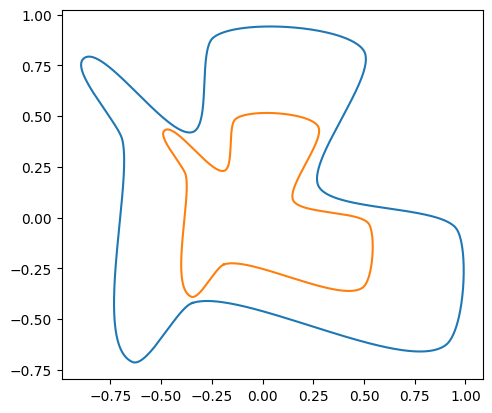

In [2]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

rad = 0.2
edgy = 0.05

# for c in np.array([[0,0], [0,0]]):
c = [-1,-1]
# a = get_random_points(n=10, scale=2) + c

# a = np.array([[1.29472513, 1.14157785],
#        [1.119077  , 1.3127037 ],
#        [1.50111844, 1.78650005],
#        [1.52040961, 1.64019978],
#        [1.67219794, 1.45177693],
#        [1.78290983, 1.82983384],
#        [1.01242472, 1.11953073]])

a = np.array([[-0.8836306 ,  0.78267166],
       [ 0.4994323 ,  0.82252129],
       [ 0.9025458 , -0.62873755],
       [ 0.27695333,  0.15364517],
       [-0.24462855,  0.88574196],
       [ 0.95784166, -0.05776322],
       [-0.6417497 , -0.71148342],
       [-0.34629548, -0.42077046],
       [-0.69191336,  0.38650681],
       [-0.34438662,  0.42199662]])
x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
# xc = x.max() - x.min()
# yc = y.max() - y.min()
# p = 2*(x - x.min())/xc -1
# q = 2*(y - y.min())/yc -1

p = x
q = y
plt.plot(p,q)
plt.plot((p)*np.sqrt(.3),(q)*np.sqrt(.3))

plt.show()

In [10]:
p.shape

(1000,)

In [9]:
Z = np.zeros_like(X)
eps = 0.5
for r in np.linspace(0,5,1001):
    # R = np.sqrt(x**2 + y**2)
    xi = x*np.sqrt(r)
    yi = (y*np.sqrt(r))
    c = np.where((np.abs(X - xi)< eps) * (np.abs(Y - yi)< eps),True, False)
    Z[c] = r


NameError: name 'X' is not defined

In [3]:
def calc_intersec(p,q,R,a):
    alpha = (p**2 + q**2)
    return (-alpha + np.sqrt(alpha**2 + 4*a*R**2))/(2*a)

In [11]:
t = np.linspace(0,2*np.pi, 1000)
p = np.sin(t)
q = np.cos(t)

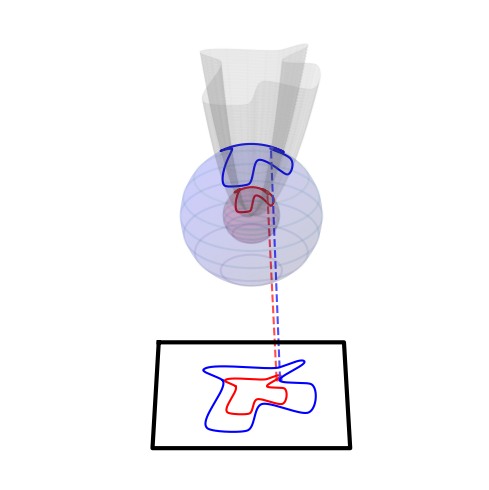

In [60]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')
b = .2
r1 = 2
r2 = 5
max_r = 25
radius = np.linspace(0,max_r,100)
t = np.arange((len(x)))
T,R = np.meshgrid(t,radius)

sx = p[T]*np.sqrt(R)
sy = q[T]*np.sqrt(R)
sz = np.sqrt(b)*R
ax.plot_surface(sx,sy,sz,color='gray',alpha = .1)
ax.plot_wireframe(sx,sy,sz, color='gray',alpha = .01)
# ax.contour(sx,sy,sz)


r=r1
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
xc = r*np.cos(u)*np.sin(v)
yc = r*np.sin(u)*np.sin(v)
zc = r*np.cos(v)

ax.plot_surface(xc,yc,zc,color='red', alpha=0.1)
# ax.plot_wireframe(xc,yc,zc,color=(1,.5,.5), alpha=0.1)
ax.contour(xc,yc,zc, alpha=0.1)


rz = calc_intersec(p,q,r,b)
ax.plot(p*np.sqrt(rz),q*np.sqrt(rz),zs=rz*np.sqrt(b),color='red',alpha = 1)

r=r2
xc = r*np.cos(u)*np.sin(v)
yc = r*np.sin(u)*np.sin(v)
zc = r*np.cos(v)

ax.plot_surface(xc,yc,zc,color='blue', alpha=0.1)
# ax.plot_wireframe(xc,yc,zc,color=(.5,.5,1), alpha=0.1)
ax.contour(xc,yc,zc, alpha=0.1)


rz = calc_intersec(p,q,r,b)
ax.plot(p*np.sqrt(rz),q*np.sqrt(rz),zs=rz*np.sqrt(b),color='blue',alpha = 1)
ax.axis('off')
# ax.plot(0,0,0,'ko')


plt.tight_layout()

# ax2 = fig.add_subplot(212)
# ax2.plot(x,y,'b')
# ax2.plot((x)*.8,(y)*.8,'r')
# ax2.set_xlim(ax.get_xlim())
# ax2.set_ylim(ax.get_ylim())
# ax2.axis('off')
# # plt.tight_layout()

scaling_fat = 5
j =340
offset = -15

r=r1
rz1 = calc_intersec(p[j],q[j],r,b)
# ax.plot(p[j]*np.sqrt(rz1),q[j]*np.sqrt(rz1),zs=rz1*np.sqrt(b),color='k',alpha = 1, marker = '.')
ax.plot([p[j]*np.sqrt(.3)*scaling_fat,p[j]*np.sqrt(rz1)], [q[j]*np.sqrt(.3)*scaling_fat, q[j]*np.sqrt(rz1)], '--', color = (1,.3,.3), zs = [offset, rz1*np.sqrt(b)], marker = '.', markersize = 4) # projection line
ax.plot(p*np.sqrt(.3)*scaling_fat,q*np.sqrt(.3)*scaling_fat,zs = offset,color='r')
# ax.plot(p[j]*np.sqrt(.3),q[j]*np.sqrt(.3),zs = offset,color='k',marker='.',markersize=0.5)


#Blue
j =390
r=r2
rz1 = calc_intersec(p[j],q[j],r,b)
ax.plot(p[j]*np.sqrt(rz1),q[j]*np.sqrt(rz1),zs=rz1*np.sqrt(b),color='k',alpha = 1)
ax.plot([p[j]*scaling_fat,p[j]*np.sqrt(rz1)], [q[j]*scaling_fat, q[j]*np.sqrt(rz1)], '--', color = (.3,.3,1), zs = [offset, rz1*np.sqrt(b)], marker = '.', markersize = 4) # projection line

ax.plot(p*scaling_fat,q*scaling_fat,zs = offset,color='b')
# ax.plot(p[j],q[j],zs = offset,color='k',marker='.',markersize=0.5)

box_scale = 7

box_x = np.array([-1,-1,1, 1,-1]) * box_scale
box_y = np.array([-1, 1,1,-1,-1]) * box_scale
ax.plot(box_x,box_y,zs = offset, color = 'black', lw = 3)
# ax.text(box_x[2]+.5, box_y[2]+.2,z=offset, s = '$\mathcal{F}$',fontsize = 20)
# ax.text(box_x[2]+.5, box_y[2]+.2,z=20, s = '$\mathcal{H}$',fontsize = 20, color = 'gray')
ax.set_box_aspect((np.ptp(sz),np.ptp(sz), np.ptp(sz)))

side_lim = np.maximum(r2,box_scale)
ax.set_xlim(-side_lim,side_lim)
ax.set_ylim(-side_lim,side_lim)
ax.set_zlim(offset,max_r*np.sqrt(b))
fig.tight_layout()
ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()),np.ptp(ax.get_zlim())))


ax.view_init(elev=30, azim=0, roll=0)
fig.savefig('hilbert_projection_aspect.png', dpi=300, bbox_inches = 'tight')

In [52]:
ax.get_zlim(), b, np.sqrt(b)

((-15.0, 4.47213595499958), 0.2, 0.4472135954999579)

In [142]:
fig.savefig('ilustration.png', format='png', bbox_inches='tight')
fig.savefig('ilustration.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [26]:
len(p)

700